In [90]:
# First, we will load up some dependencies. Make sure you can get through this part first. 
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline  

Now we are going to load the data in. I have already saved off two images, a '9' and a '4', to keep things simple for us. We also reshape them into their native [28 x 28] size, so that we can later corrupt them in this domain, and then reconstruct them.

In [35]:
data = (np.load('data_to_train_on.npy')).astype(np.float32).reshape(2,28,28)

What does our data look like? Well they are just two binary images, showing a figure '9', and a figure '4'. Let's image them just to take a peek at what they look like. 

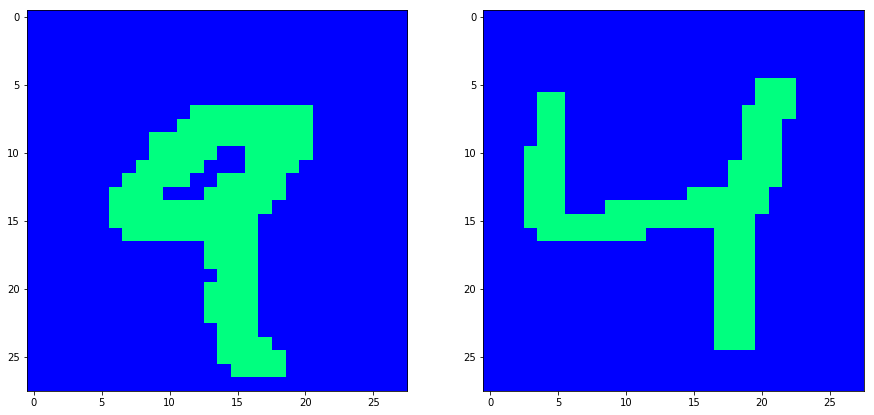

In [36]:
# Show the training data - it's just two different samples that we are going to want the Hopfield net to store.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(data[0], interpolation='None', cmap='winter')
ax[1].imshow(data[1], interpolation='None', cmap='winter')
plt.show()

In [46]:
# Here, we will set some initial parameters, as well as define some helper functions used in the training and fielding
# of the Hopfield net

# This is a cool way to make it so that we can store ad-hoc members in a struct. I find it handy, where I use 
# "N" for "number of things", and "I" to keep track of various indices. Personal preference.
N = lambda:0
I = lambda:0

# Train function for the hopfield net. (By updating the weights)
def train_hopfield_weights(data, weights):
    # data : A [d x rows x cols] numpy array of data. 'd' is the number of data samples used to train. (In this case 2)
    # weights : A [rows*cols x rows*cols] matrix of the hopfield weights, initialized with 0s.

    # First, we vectorize our data:
    data = data.reshape((-1, 1, data.shape[1]*data.shape[2]))
    
    # Number of patterns to store/train with.
    N.data = data.shape[0]    

    # Loop through all data samples.
    for dd in xrange(N.data):

        # Data cross-product gives neural hopfield update rule.
        w_update = data[dd].T * data[dd]
        
        # Sum all pattern cross-products.
        weights += w_update

    # Hopfield nets are a form of RNNs, albeit without self-connections, and so, we need to make sure that the 
    # diagonal elements of the final weight matrix are zero. 
    np.fill_diagonal(weights, 0)
                
    # Return our new weights
    return (weights.astype(np.float32))


# This function computes the Hopfield nets' energy.
def energy(x, w):
    # x: [1 x N] data vector
    # w: [N x N] hopfield net weight matrix.
    energy = -x.dot(w).dot(x.T)
    return energy

# We will use this function to take in a good image, and corrupt it, based on two types of noise, either bernouli noise,
# (where every pixel is randomly flipped in sign), or masking noise, where we blot out entire sections of the image. Our
# Hopfield net will be able to recover the original image via energy minimization as we will see.
def corrupt_input(image_to_corrupt, method, bernouli_noise_probability = 0.1, mask_value = -1, mask_matrix=np.zeros((2,2))):
    if method == 'bernouli':
        noise_image = (-1*np.random.binomial(1, bernouli_noise_probability, (image_to_corrupt.shape[0], image_to_corrupt.shape[1]))).astype(np.float32)
        noise_image[noise_image==0] = 1
        corrupted_image = noise_image * image_to_corrupt
    elif method == 'mask':
        corrupted_image = np.copy(image_to_corrupt)
        corrupted_image[mask_matrix[0,0]:mask_matrix[0,1], 
                        mask_matrix[1,0]:mask_matrix[1,1]] = mask_value

    return corrupted_image    

OK this is where the fun begins! We are now going to train our Hopfield net. The objective is simple: We want it to store those two patterns we are feeding it, such that a faithful reconstruction can be performed, when _corrupted_ versions of either of those inputs is given later in the future. 

In [64]:
# Train the Hopfield net! 

# So there are as many neurons as pixels per pattern, and this is what this computes.
N.neurons = data.shape[1] * data.shape[2]

# The weight matrix encodes the relationships between neurons, in a Hebbian sense.
weights = np.zeros((N.neurons, N.neurons)).astype(np.float32)

# Great - we are all set - now we train! 
weights = train_hopfield_weights(data, weights)


Now at this point, we have a trained weight matrix, encoded with the pattern '4' and pattern '9'. (We will see later on that Hopfield nets aren't that memory efficient, but it's still amazing what they are capable of). Now remember - the objective here is simple: We want it to store those two patterns we are feeding it, such that faithful reconstruction can later be performed, when _corrupted_ versions of either of those inputs are presented. But does it work? Let's find out! 

We can corrupt our data in many ways - and here, we can add two types of noise: Bernouli noise, (where every pixel is flipped in sign with a certain probability) and/or masking noise, (where we simply blot out certain regions with one particular sign).


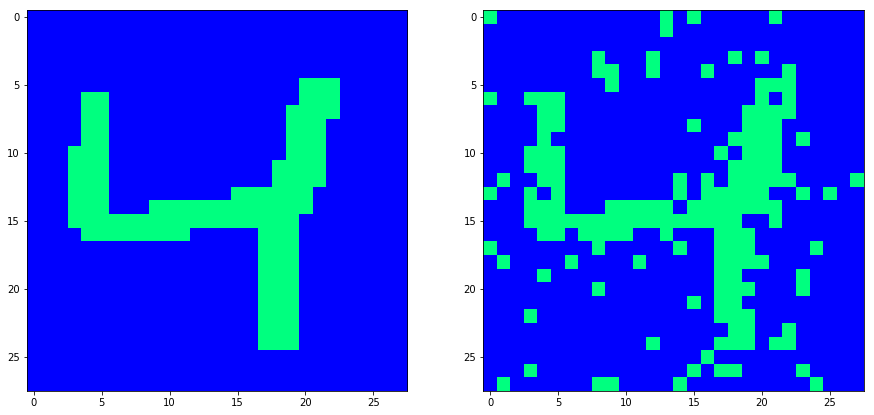

In [72]:
# Let's pick one the image '4', and corrupt it.
image = data[1]

# Corrupt the image with bernouli noise.
corrupted_image = corrupt_input(image, method='bernouli', bernouli_noise_probability=0.1)

# Let's see the original image, as well as the corrupted version.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image, interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image, interpolation='None', cmap='winter')
plt.show()


This is the moment of truth: With a corrupted input now at hand, we then present this to our trained net, and hope that it denoises it. We do so by picking pixels at random, and then evaluating their activation functions, based on the current input configuration, (corrupted image), and the set weights, (that do not change here, as the net has already been trained). 

Since the Hopfield net stores patterns as minimal enery states, every iteration where we update a neuron/pixel should place the net into a lower energy configuration - that is - closer to the original pattern we stored - the weights are designed to do so after all.

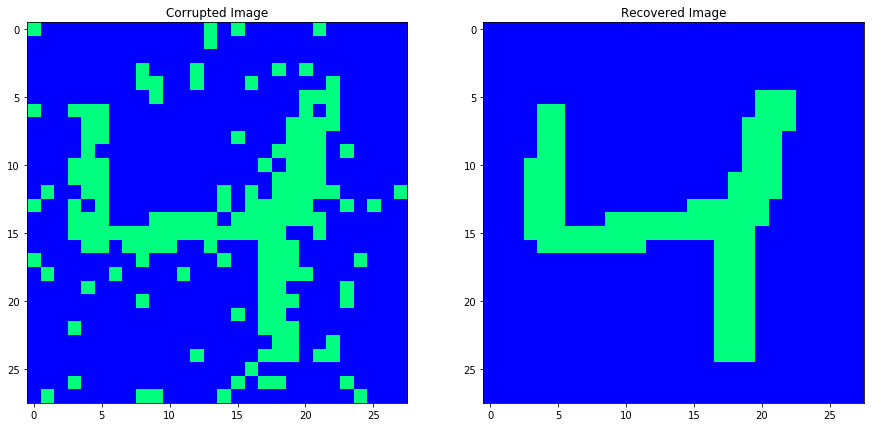

In [83]:
# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image, interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')

# The number of iterations where we randomly update neurons/pixels
N.iterations = 5000

# This will store the energy of the Hopfield net.
energy_vec = np.zeros((1,N.iterations))

# Loop through, and recover the image from it's corrupted self. (And vectorize)
cleaned_image = np.copy(corrupted_image).reshape(1,784)
for nn in xrange(N.iterations):

    # Compute energy:
    energy_vec[0,nn] = energy(cleaned_image, weights)

    # Pick a neuron at random to evaluate.    
    I.index_to_clean = np.random.randint(N.neurons)

    cleaned_image[0,I.index_to_clean] = np.sign(cleaned_image.dot(weights[:,I.index_to_clean]))

    # We will show the cleaned_image as it is being cleaned! (Image only every modulo 100 for speed)
    if (nn % 100) == 0:
        ax[1].cla()
        ax[1].imshow(np.reshape(cleaned_image, (28,28)), interpolation='None', cmap='winter')
        ax[1].set_title('Recovered Image')


Our original pattern has been very nicely recovered. What about masking noise _and_ bernouli noise? Let's try that.


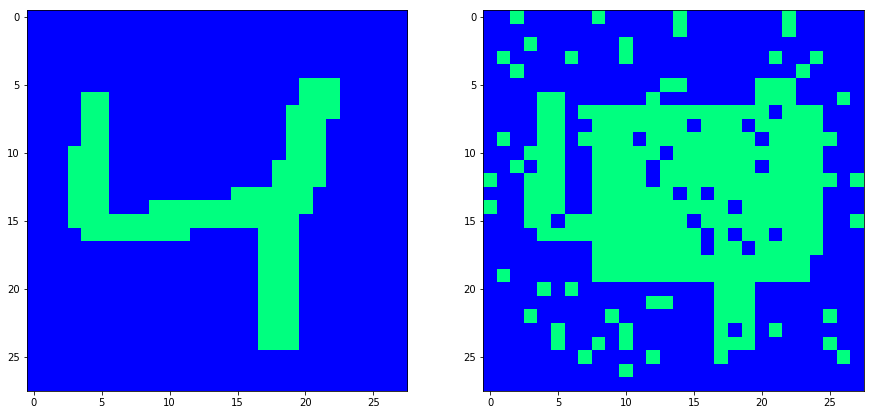

In [84]:
# Masking and Bernouli noise
mask_matrix = np.zeros((2,2)).astype(np.int32)
mask_matrix[0,0] = 7
mask_matrix[0,1] = 20
mask_matrix[1,0] = 8
mask_matrix[1,1] = 25
corrupted_image = corrupt_input(image, method='mask', mask_value=1, mask_matrix=mask_matrix)
corrupted_image = corrupt_input(corrupted_image, method='bernouli', bernouli_noise_probability=0.1)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5))
ax[0].imshow(image, interpolation='None', cmap='winter')
ax[1].imshow(corrupted_image, interpolation='None', cmap='winter')
plt.show()


Now that's one ugly looking '4'. Can we recover the hidden pattern?

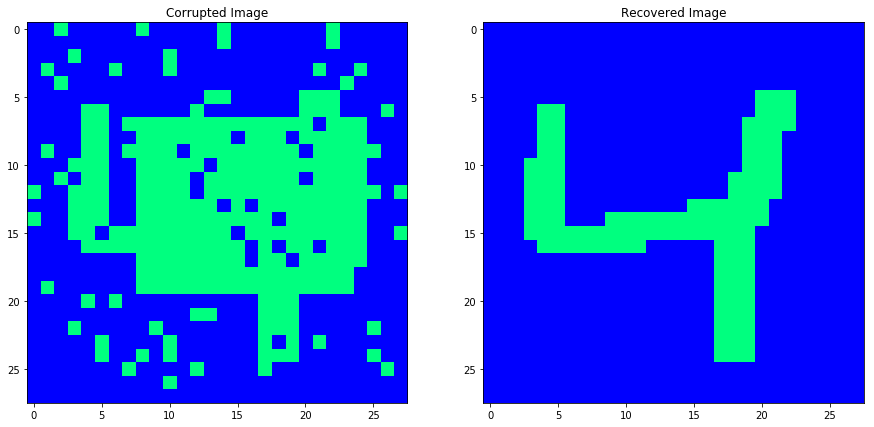

In [86]:
# (For imaging purposes)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 7.5))
ax[0].imshow(corrupted_image, interpolation='None', cmap='winter')
ax[0].set_title('Corrupted Image')

# The number of iterations where we randomly update neurons/pixels
N.iterations = 5000

# This will store the energy of the Hopfield net.
energy_vec = np.zeros((1,N.iterations))

# Loop through, and recover the image from it's corrupted self. (And vectorize)
cleaned_image = np.copy(corrupted_image).reshape(1,784)
for nn in xrange(N.iterations):

    # Compute energy:
    energy_vec[0,nn] = energy(cleaned_image, weights)

    # Pick a neuron at random to evaluate.    
    I.index_to_clean = np.random.randint(N.neurons)

    # Update the neuron in question, based on it's activation.
    cleaned_image[0,I.index_to_clean] = np.sign(cleaned_image.dot(weights[:,I.index_to_clean]))

    # We will show the cleaned_image as it is being cleaned! (Image only every modulo 100 for speed)
    if (nn % 100) == 0:
        ax[1].cla()
        ax[1].imshow(np.reshape(cleaned_image, (28,28)), interpolation='None', cmap='winter')
        ax[1].set_title('Recovered Image')


Marvelously recovered. The Hopfield energy plotted as the recovery iteration index is shown below. We can see that as the recovery process was being run, the total net energy was being decreased.

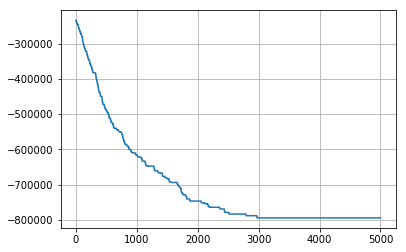

In [93]:
# Plot the Hopfield energy during recovery
plt.plot(energy_vec.T); plt.grid('on'); plt.show()


Now this is exactly what it means to be 'content addressable' - the fact that we are able to 'snap back' to a previous pattern among many patterns, starting from a corrupted variant was perhaps one of the first success stories of the associationist movement - Hopefield nets - totally connected RNNs, where the relationships between neurons/pixels are impressed into the weights as minimum energy states. In doing so, the iterative changing of neural activations becomes exactly like finding a configuration of least energy - something that is found in nature all the time.
